# Estuardo Funes Solares
# Carnet: 20032042
# Tarea 3: Pipeline

In [1]:
# Se importan las librerías que se van a utilizar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.preprocessing import StandardScaler


from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

#import myPreprocessors as mypp #nuestra librerías de transformaciones.

import scipy.stats as stats
import joblib

In [2]:
# Se ve la estructura del dataset, 14,447 registros y 11 variables o columnas

data = pd.read_csv('train.csv')
data.shape

(14447, 11)

In [3]:
# Vemos una muestra de 20 registros del dataset

data.head(20)

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN
5,7653,-118.27,33.83,28,2152,415.0,1623,429,4.3500,200500.0,<1H OCEAN
6,14056,-117.13,32.75,23,3999,1182.0,2051,1130,2.1292,135000.0,NEAR OCEAN
7,18819,-120.24,39.67,40,690,129.0,305,110,2.3625,62500.0,INLAND
8,17145,-122.19,37.45,18,1636,414.0,853,439,5.1032,464600.0,NEAR OCEAN
9,16187,-121.29,37.95,52,107,79.0,167,53,0.7917,22500.0,INLAND


### Se eliminan las columnas de Longitud y Latitud, ya que pueden haber valores negativos, los cuales no los acepta la función BoxCox, 
### Además de ser columnas que para nuestro análisis no se consideran de impacto si no más informativas

In [6]:
data = data.drop(['longitude','latitude'], axis=1)

# 1. Función para Identificar los Tipos de Variables del Dataset

In [7]:
def getColumnTypes(dataset):
     """
        Descripcion: Esta función extrae el tipo de dominio de las columnas de un dataset.
        Entradas: Pandas Dataframe  
        Salida: Tupla con arreglo que contine nombres de las columnas.
     """
     continuas = []
     discretas = []
     categoricas = []
     for col in dataset.columns:
          if((dataset[col].dtype == 'int64') or (dataset[col].dtype == 'float64')):
               if(len(dataset[col].unique()) > 30): #criterio para discretas o continuas
                    continuas.append(col)
               else:
                    discretas.append(col)
          else:
               categoricas.append(col)

     return continuas, discretas, categoricas

In [8]:
# Se imprimen las diferentes categorías de las columnas, siendo estas continuas, discretas y categóricas

continuas, discretas, categoricas = getColumnTypes(data)
print(continuas)
print(discretas)
print(categoricas)

['id', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
[]
['ocean_proximity']


#### Como podemos ver solo hay variables continuas y categóricas, no hay variables discretas.
#### Y solo tenemos 1 variable categórica, el resto son continuas

# 2. Separamos Datos de Entrenamiento y Prueba

In [9]:
# si hubiera puesto X_ es una matriz, x_ es un vector
X_train, X_test, y_train, y_test = train_test_split(data.drop(['id', 'median_house_value'], axis=1), # Se ingresan las variables en este orden (x_train, x_test, y_train, y_test)
                                                                     data['median_house_value'], 
                                                                     test_size=0.3,
                                                                     random_state = 2023) # todos tengamos la misma estructura aleatoria

In [10]:
X_train

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1220,34,1723,279.0,617,252,6.7501,<1H OCEAN
6446,10,2980,585.0,1593,562,3.2850,<1H OCEAN
10521,39,2002,416.0,1166,395,1.7257,NEAR BAY
13367,32,1260,382.0,1434,342,2.0286,<1H OCEAN
4439,21,2630,446.0,1789,389,5.0543,<1H OCEAN
...,...,...,...,...,...,...,...
5852,25,3095,514.0,1251,507,5.5388,<1H OCEAN
6049,26,3141,670.0,1572,724,3.3472,<1H OCEAN
2743,21,1899,447.0,1133,391,1.8636,INLAND
5657,34,2231,545.0,1568,510,1.5217,INLAND


In [11]:
X_test

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12607,30,2695,424.0,1098,420,5.3972,NEAR OCEAN
13211,29,3558,447.0,1097,445,8.0930,<1H OCEAN
12576,29,2929,640.0,1618,584,3.6875,<1H OCEAN
8209,16,3784,577.0,1615,525,4.2333,INLAND
8554,27,1797,538.0,1610,531,4.2422,<1H OCEAN
...,...,...,...,...,...,...,...
2319,14,6438,1719.0,1586,691,1.6136,INLAND
979,26,1639,352.0,1222,395,1.7656,INLAND
6034,24,4195,706.0,2200,647,4.3451,<1H OCEAN
13688,10,4159,608.0,2089,591,5.5261,INLAND


#### La Variable Categórica vemos cuántos valores diferentes hay en dicha columna

In [12]:
unique_values_ocean_proximity = data['ocean_proximity'].unique()
print(unique_values_ocean_proximity)


['<1H OCEAN' 'INLAND' 'NEAR BAY' 'NEAR OCEAN' 'ISLAND']


In [13]:
data['ocean_proximity'].value_counts()

<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64

In [14]:
y_train

1220     400000.0
6446     218300.0
10521     91500.0
13367    122900.0
4439     232000.0
           ...   
5852     352100.0
6049     237400.0
2743      67900.0
5657      60300.0
4951     139200.0
Name: median_house_value, Length: 10112, dtype: float64

In [15]:
y_test

12607    362300.0
13211    379600.0
12576    213200.0
8209     220300.0
8554     237500.0
           ...   
2319      67400.0
979       68000.0
6034     177800.0
13688    132000.0
8400     500001.0
Name: median_house_value, Length: 4335, dtype: float64

# 3. Revisar si hay columnas con NaNs

In [16]:
# Porcentaje de NaNs en las columnas, se puede ver que solo tenemos NaN en la variable total_bedrooms

Porcentajes =  data.isnull().mean().sort_values(ascending=False)
Porcentajes.head(20)

total_bedrooms        0.009483
id                    0.000000
housing_median_age    0.000000
total_rooms           0.000000
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

#### Solamente la variable total_bedrooms tiene NaNs y son 0.009483, es decir, 0.9483% (menos al 5%) por lo que si podemos hacer imputación

# 4. Gráfica de Barras de Valores NaNs

In [17]:
unique_values_total_bedrooms = data['total_bedrooms'].unique()
print(unique_values_total_bedrooms)

[ 358.  109.  184. ... 2568. 1387. 1589.]


In [18]:
data['total_bedrooms'].value_counts()

280.0     41
393.0     40
322.0     38
361.0     36
295.0     36
          ..
1439.0     1
1237.0     1
1328.0     1
1521.0     1
1159.0     1
Name: total_bedrooms, Length: 1778, dtype: int64

### Creación de Gráfica de Barras

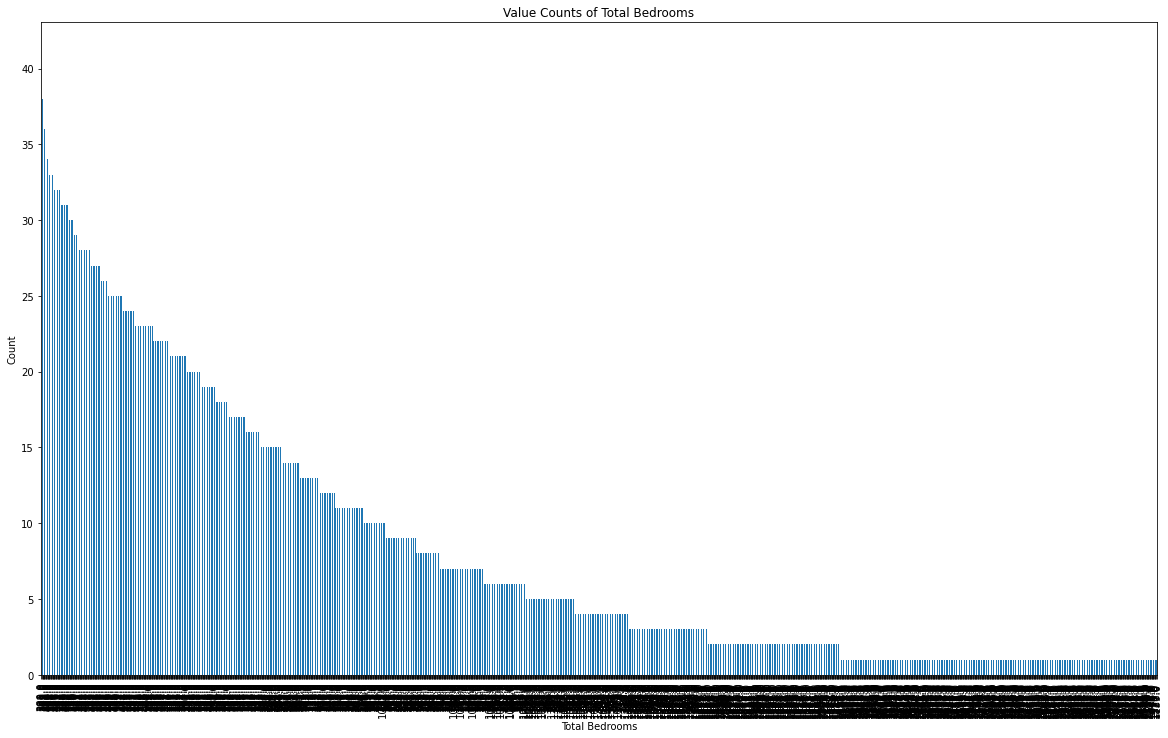

In [19]:

# Calculate the value counts
value_counts = data['total_bedrooms'].value_counts()

# Create a bar plot
plt.figure(figsize=(20, 12))  
value_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Total Bedrooms')
plt.ylabel('Count')
plt.title('Value Counts of Total Bedrooms')


plt.show()


# 5. Corroborar columnas con Ceros (0)

In [20]:
# Revisar si hay columnas con valores "0"
zeros_in_cols = (data == 0).sum() > 0

# Resultado
print(zeros_in_cols)

id                    False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool


In [21]:
# Columnas con valores "0"

cols_with_zeros = zeros_in_cols[zeros_in_cols].index.tolist()
cols_with_zeros

[]

# 6. Hacemos imputación de Media en Columna Numérica (total_bedrooms)

In [22]:
total_bedrooms_media = data['total_bedrooms'].mean()

print(f"Media de Columna total_bedrooms:  {total_bedrooms_media}")

Media de Columna total_bedrooms:  537.7787561146051


In [23]:
data['total_bedrooms_media']=np.round(data['total_bedrooms'].fillna(total_bedrooms_media))

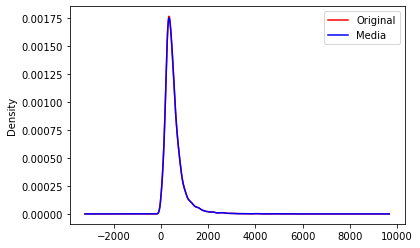

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

data['total_bedrooms'].plot.density(color='red', label='Original')
data['total_bedrooms_media'].plot.density(color='blue', label='Media')

ax.legend()

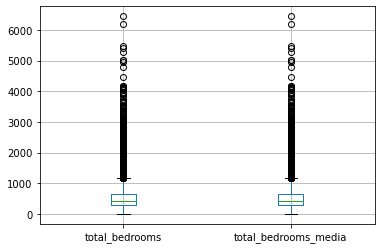

In [25]:
data[['total_bedrooms', 'total_bedrooms_media']].boxplot()
plt.show()

#### Podemos visualizar en el registro (línea) 18 como sería la imputación de los NaNs por la Media

In [26]:
# Confirmación de que si se hizo correctamente la imputación de media

data[['total_bedrooms', 'total_bedrooms_media']].head(20)

,total_bedrooms,total_bedrooms_media
0,358.0,358.0
1,109.0,109.0
2,184.0,184.0
3,24.0,24.0
4,1352.0,1352.0
5,415.0,415.0
6,1182.0,1182.0
7,129.0,129.0
8,414.0,414.0
9,79.0,79.0


In [27]:
data.head(20)

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms_media
0,9744,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN,358.0
1,13893,37,452,109.0,184,59,3.7292,65800.0,INLAND,109.0
2,18277,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN,184.0
3,16176,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY,24.0
4,8843,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN,1352.0
5,7653,28,2152,415.0,1623,429,4.3500,200500.0,<1H OCEAN,415.0
6,14056,23,3999,1182.0,2051,1130,2.1292,135000.0,NEAR OCEAN,1182.0
7,18819,40,690,129.0,305,110,2.3625,62500.0,INLAND,129.0
8,17145,18,1636,414.0,853,439,5.1032,464600.0,NEAR OCEAN,414.0
9,16187,52,107,79.0,167,53,0.7917,22500.0,INLAND,79.0


# 7. Frequency Encoding

### Se hace proceso de Frequency Encoding a la única variable categórica <b>"ocean_proximity"<b/>

In [28]:
def freq_encoding (data_freq_encoding, cat_cols):
    for col in cat_cols:
        freq = data_freq_encoding[col].value_counts()
        data_freq_encoding[f'{col}_freq'] = data_freq_encoding[col].map(freq)
    return data_freq_encoding 

In [29]:
data_freq_encoding = freq_encoding(data, categoricas)

### Se hace la revión para comprobar que haya funcionado bien

In [30]:
data_freq_encoding.head()

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms_media,ocean_proximity_freq
0,9744,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN,358.0,6384
1,13893,37,452,109.0,184,59,3.7292,65800.0,INLAND,109.0,4577
2,18277,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN,184.0,6384
3,16176,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY,24.0,1619
4,8843,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN,1352.0,6384


#### Se crea un BackUp del DataFrame

In [31]:
data_backup = data.copy()
data_backup.head(20)

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms_media,ocean_proximity_freq
0,9744,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN,358.0,6384
1,13893,37,452,109.0,184,59,3.7292,65800.0,INLAND,109.0,4577
2,18277,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN,184.0,6384
3,16176,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY,24.0,1619
4,8843,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN,1352.0,6384
5,7653,28,2152,415.0,1623,429,4.3500,200500.0,<1H OCEAN,415.0,6384
6,14056,23,3999,1182.0,2051,1130,2.1292,135000.0,NEAR OCEAN,1182.0,1865
7,18819,40,690,129.0,305,110,2.3625,62500.0,INLAND,129.0,4577
8,17145,18,1636,414.0,853,439,5.1032,464600.0,NEAR OCEAN,414.0,1865
9,16187,52,107,79.0,167,53,0.7917,22500.0,INLAND,79.0,4577


### Sustituyo las columnas donde hice la imputación de valores numéricos en el dataset original

In [32]:
data['total_bedrooms'] = data['total_bedrooms_media']

In [33]:
data['ocean_proximity'] = data['ocean_proximity_freq']

In [34]:
data.head(20)

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms_media,ocean_proximity_freq
0,9744,15,2191,358.0,1150,330,4.7969,227500.0,6384,358.0,6384
1,13893,37,452,109.0,184,59,3.7292,65800.0,4577,109.0,4577
2,18277,35,1172,184.0,512,175,7.3561,500001.0,6384,184.0,6384
3,16176,52,126,24.0,37,27,10.2264,225000.0,1619,24.0,1619
4,8843,28,4001,1352.0,1799,1220,2.5784,272900.0,6384,1352.0,6384
5,7653,28,2152,415.0,1623,429,4.3500,200500.0,6384,415.0,6384
6,14056,23,3999,1182.0,2051,1130,2.1292,135000.0,1865,1182.0,1865
7,18819,40,690,129.0,305,110,2.3625,62500.0,4577,129.0,4577
8,17145,18,1636,414.0,853,439,5.1032,464600.0,1865,414.0,1865
9,16187,52,107,79.0,167,53,0.7917,22500.0,4577,79.0,4577


In [35]:
# Eliminamos las columans repetidas donde hicimos la imputación de variables numéricas para no tener columnas duplicadas.

data = data.drop(['total_bedrooms_media','ocean_proximity_freq',], axis=1)

In [36]:
data.head(20)

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,15,2191,358.0,1150,330,4.7969,227500.0,6384
1,13893,37,452,109.0,184,59,3.7292,65800.0,4577
2,18277,35,1172,184.0,512,175,7.3561,500001.0,6384
3,16176,52,126,24.0,37,27,10.2264,225000.0,1619
4,8843,28,4001,1352.0,1799,1220,2.5784,272900.0,6384
5,7653,28,2152,415.0,1623,429,4.3500,200500.0,6384
6,14056,23,3999,1182.0,2051,1130,2.1292,135000.0,1865
7,18819,40,690,129.0,305,110,2.3625,62500.0,4577
8,17145,18,1636,414.0,853,439,5.1032,464600.0,1865
9,16187,52,107,79.0,167,53,0.7917,22500.0,4577


### Corroborar columnas ya sin NaNs

In [37]:
# Porcentaje de NaNs en las columnas, se puede ver que solo tenemos NaN en la variable total_bedrooms

Porcentajes_imputacion =  data.isnull().mean().sort_values(ascending=False)
Porcentajes_imputacion.head(20)

id                    0.0
housing_median_age    0.0
total_rooms           0.0
total_bedrooms        0.0
population            0.0
households            0.0
median_income         0.0
median_house_value    0.0
ocean_proximity       0.0
dtype: float64

# 8. Transformación de Variables

In [38]:
dataset = data
col='total_rooms'


def plot_density_qq(dataset, col):
    #Esta función muestra la grafica de densidad y el plot QQ para verificar normalidad#
    plt.figure(figsize=(15, 6))
    plt.subplot(1,2,1)
    dataset[col].hist(bins=30)

    plt.subplot(1,2,2)
    stats.probplot(dataset[col], dist= 'norm', plot= plt)

    plt.show()

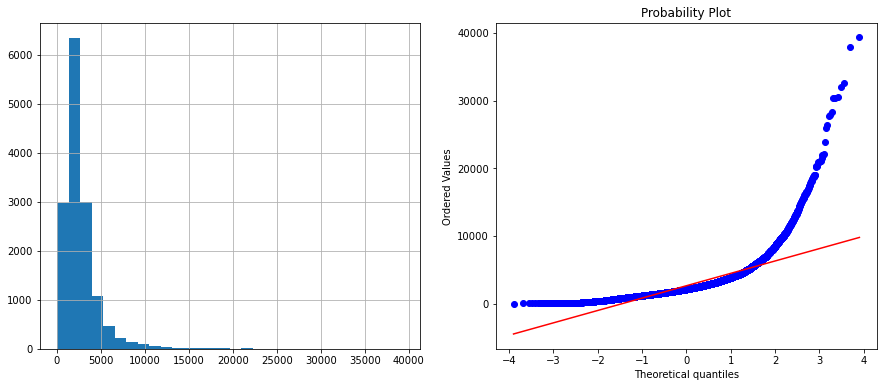

In [39]:
plot_density_qq(data, 'total_rooms')

### Se hace otro tipo de transformaciones para ver cuál es la mejor opción

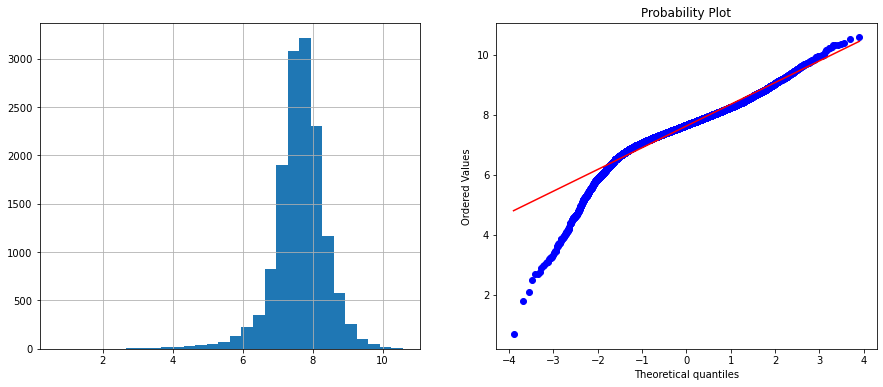

In [40]:
data['total_rooms_log'] = np.log(data['total_rooms'])
plot_density_qq(data, 'total_rooms_log')

In [41]:
data.head()

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_rooms_log
0,9744,15,2191,358.0,1150,330,4.7969,227500.0,6384,7.692113
1,13893,37,452,109.0,184,59,3.7292,65800.0,4577,6.113682
2,18277,35,1172,184.0,512,175,7.3561,500001.0,6384,7.066467
3,16176,52,126,24.0,37,27,10.2264,225000.0,1619,4.836282
4,8843,28,4001,1352.0,1799,1220,2.5784,272900.0,6384,8.294300


### Se hace una función para hacerlo de manera automática

In [42]:
for col in continuas:
    asimetria = round(data[col].skew(), 4)
    kurtosis = round(data[col].kurt(), 4)
    #Validación de asimetría
    if ((asimetria <= 0.1) and (asimetria>=-0.1)):
        etiqueta_asimetria = True
    else:
        etiqueta_asimetria = False
    
    #Validación de Kurtosis
    if ((kurtosis <= 3.2) and (kurtosis >= 2.8)):
         etiqueta_kurtosis = True
    else:
        etiqueta_kurtosis = False
    
    # Conclusión de normalidad
    if (etiqueta_asimetria and etiqueta_kurtosis):
        etiqueta = "Normal"
    else:
        etiqueta = "No es Normal"
        
    print(f"{col} - Asimetría:{asimetria}, Curtosis:{kurtosis} - {etiqueta}")

id - Asimetría:0.0101, Curtosis:-1.1975 - No es Normal
housing_median_age - Asimetría:0.0435, Curtosis:-0.7915 - No es Normal
total_rooms - Asimetría:4.3856, Curtosis:36.5456 - No es Normal
total_bedrooms - Asimetría:3.5362, Curtosis:23.1426 - No es Normal
population - Asimetría:4.1319, Curtosis:42.9759 - No es Normal
households - Asimetría:3.4983, Curtosis:23.0861 - No es Normal
median_income - Asimetría:1.6659, Curtosis:5.0838 - No es Normal
median_house_value - Asimetría:0.9733, Curtosis:0.3199 - No es Normal


In [44]:
shapiro_test = stats.shapiro(data['total_rooms'])
shapiro_test

ShapiroResult(statistic=0.6815862655639648, pvalue=0.0)

In [45]:
shapiro_test = stats.shapiro(data['total_rooms_log'])
shapiro_test

ShapiroResult(statistic=0.93461674451828, pvalue=0.0)

In [46]:
shapiro_test = stats.shapiro(data['total_rooms'])
if (shapiro_test[1] < 0.05):
    print("No es normal")
else:
    print("Es normal")

No es normal


In [47]:
shapiro_test = stats.shapiro(data['total_rooms_log'])
if (shapiro_test[1] < 0.05):
    print("No es normal")
else:
    print("Es normal")

No es normal


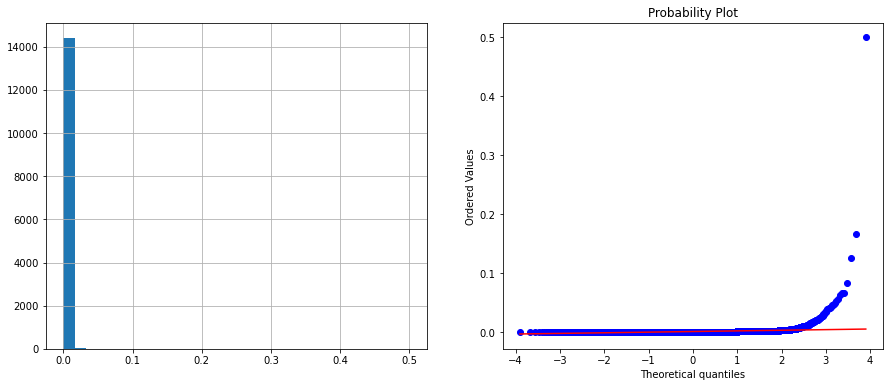

In [48]:
data['total_rooms_inv'] = (1/(data['total_rooms']))
plot_density_qq(data, 'total_rooms_inv')

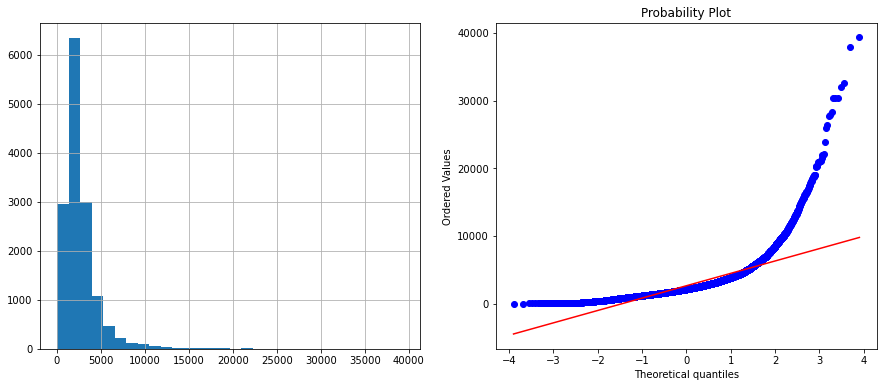

In [49]:
data['total_rooms_cuad'] = (data['total_rooms']^2)
plot_density_qq(data, 'total_rooms_cuad')

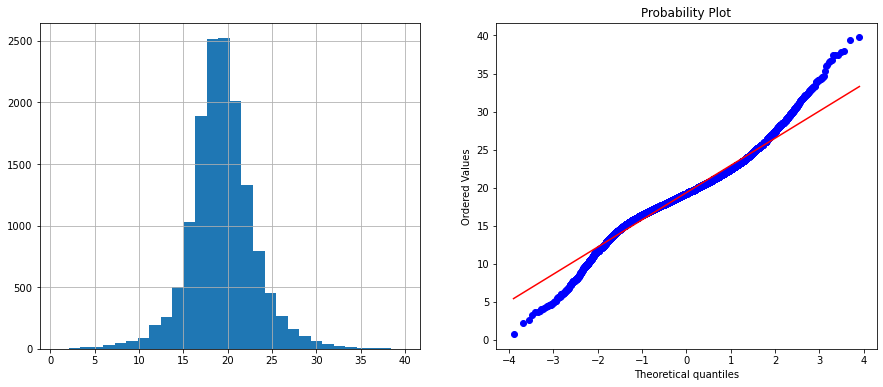

In [50]:
data['total_rooms_boxcox'],_ = stats.boxcox(data['total_rooms'])
plot_density_qq(data, 'total_rooms_boxcox')

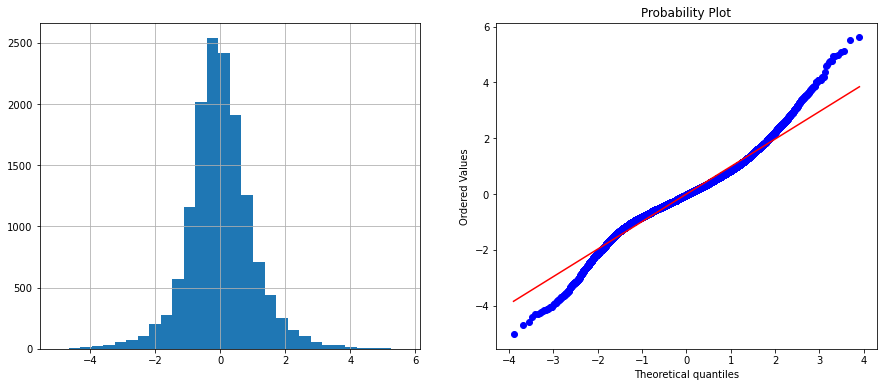

In [51]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
data['total_rooms_yeoJohnson'] = pt.fit_transform(data['total_rooms'].values.reshape(-1, 1))
plot_density_qq(data, 'total_rooms_yeoJohnson')

### Viendo todas las transformaciones, podemos concluir que las mejores son BoxCox o YeoJohnson
### por lo que se hará únicamente la transformación de BoxCox

In [52]:
data.head(40)

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_rooms_log,total_rooms_inv,total_rooms_cuad,total_rooms_boxcox,total_rooms_yeoJohnson
0,9744,15,2191,358.0,1150,330,4.7969,227500.0,6384,7.692113,0.000456,2189,19.382511,0.010943
1,13893,37,452,109.0,184,59,3.7292,65800.0,4577,6.113682,0.002212,454,12.527154,-1.881253
2,18277,35,1172,184.0,512,175,7.3561,500001.0,6384,7.066467,0.000853,1174,16.388156,-0.815245
3,16176,52,126,24.0,37,27,10.2264,225000.0,1619,4.836282,0.007937,124,8.435327,-3.010390
4,8843,28,4001,1352.0,1799,1220,2.5784,272900.0,6384,8.294300,0.000250,4003,22.665167,0.915981
5,7653,28,2152,415.0,1623,429,4.3500,200500.0,6384,7.674153,0.000465,2154,19.290898,-0.014326
6,14056,23,3999,1182.0,2051,1130,2.1292,135000.0,1865,8.293800,0.000250,3997,22.662264,0.915181
7,18819,40,690,129.0,305,110,2.3625,62500.0,4577,6.536692,0.001449,688,14.145477,-1.434377
8,17145,18,1636,414.0,853,439,5.1032,464600.0,1865,7.400010,0.000611,1638,17.934997,-0.388375
9,16187,52,107,79.0,167,53,0.7917,22500.0,4577,4.672829,0.009346,105,7.987279,-3.133766


### Se hace la transformación de BoxCox a las otras variables

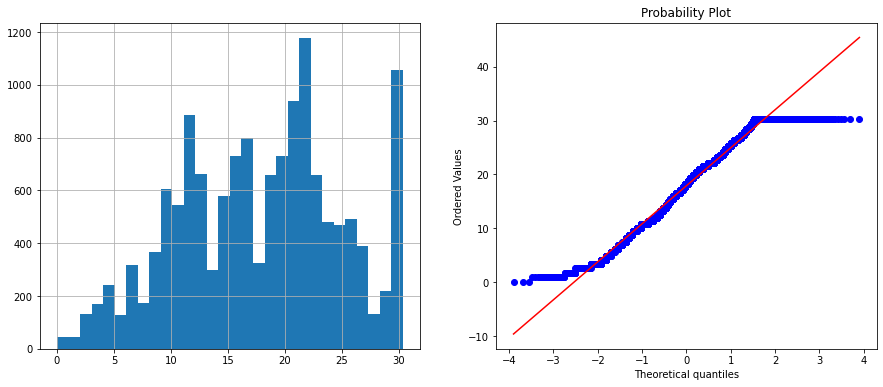

In [53]:
data['housing_median_age_boxcox'],_ = stats.boxcox(data['housing_median_age'])
plot_density_qq(data, 'housing_median_age_boxcox')

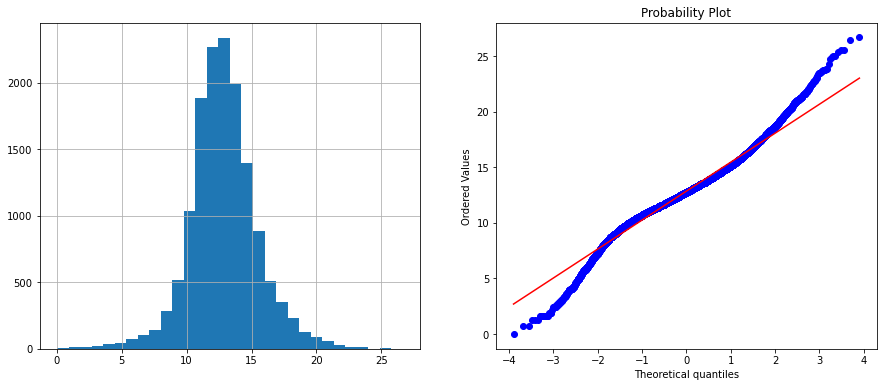

In [54]:
data['total_bedrooms_boxcox'],_ = stats.boxcox(data['total_bedrooms'])
plot_density_qq(data, 'total_bedrooms_boxcox')

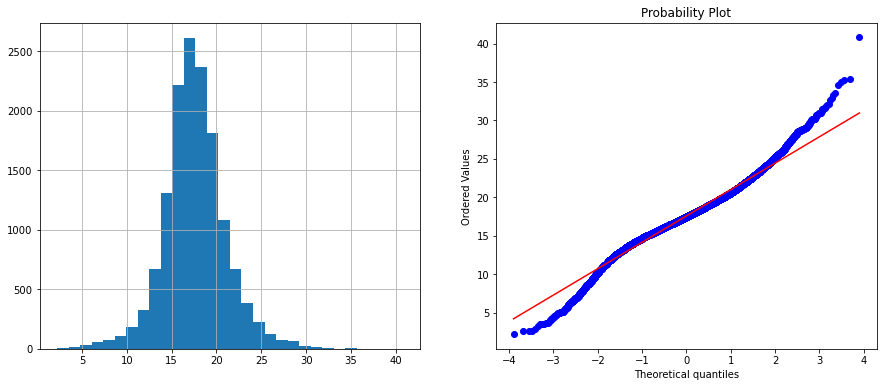

In [55]:
data['population_boxcox'],_ = stats.boxcox(data['population'])
plot_density_qq(data, 'population_boxcox')

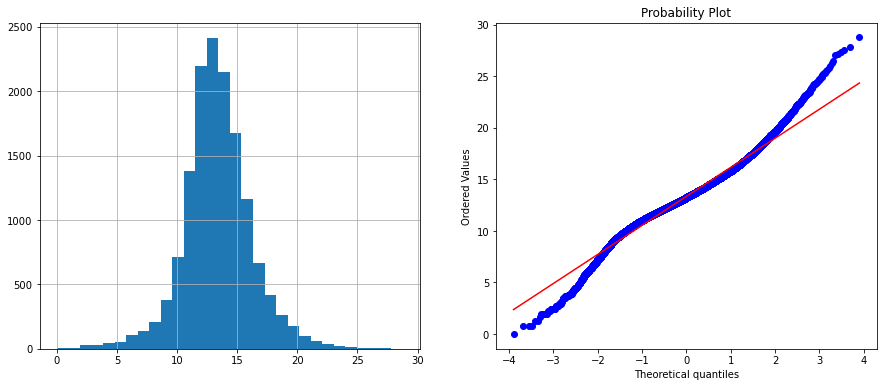

In [56]:
data['households_boxcox'],_ = stats.boxcox(data['households'])
plot_density_qq(data, 'households_boxcox')

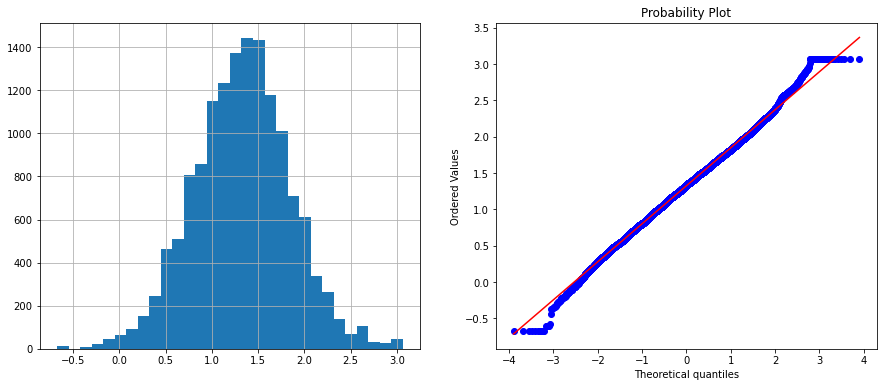

In [57]:
data['median_income_boxcox'],_ = stats.boxcox(data['median_income'])
plot_density_qq(data, 'median_income_boxcox')

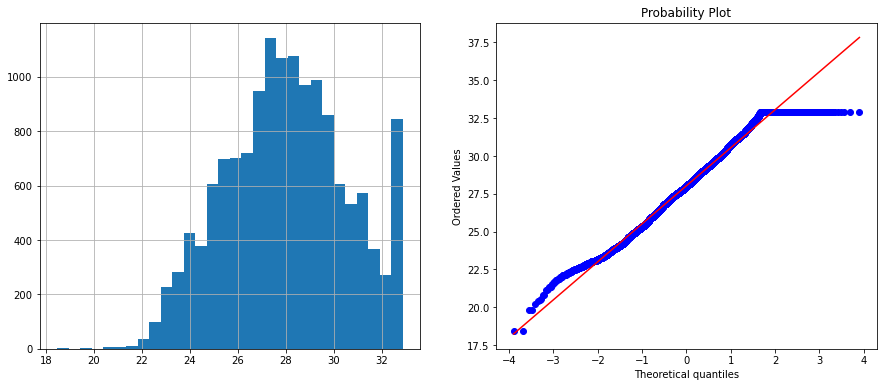

In [58]:
data['median_house_value_boxcox'],_ = stats.boxcox(data['median_house_value'])
plot_density_qq(data, 'median_house_value_boxcox')

### 

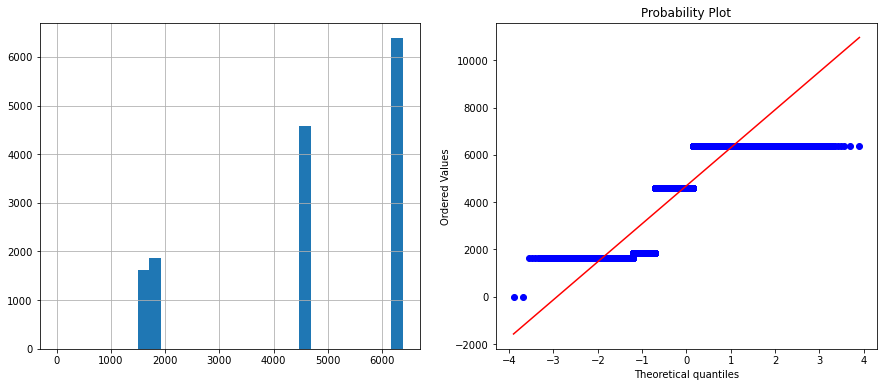

In [61]:
plot_density_qq(data, 'ocean_proximity')

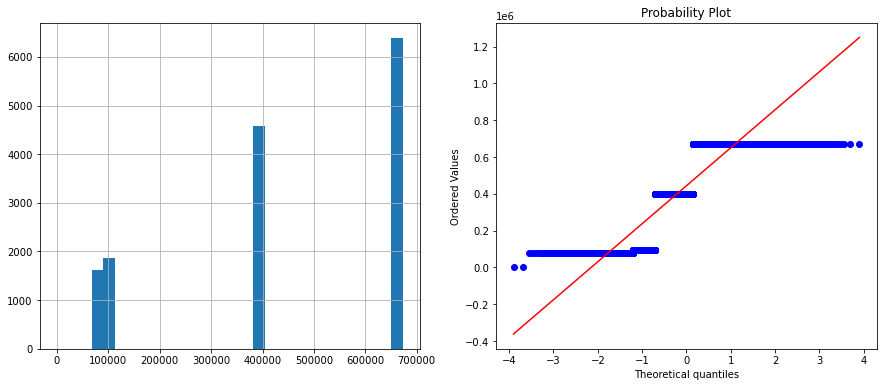

In [60]:
data['ocean_proximity_boxcox'],_ = stats.boxcox(data['ocean_proximity'])
plot_density_qq(data, 'ocean_proximity_boxcox')

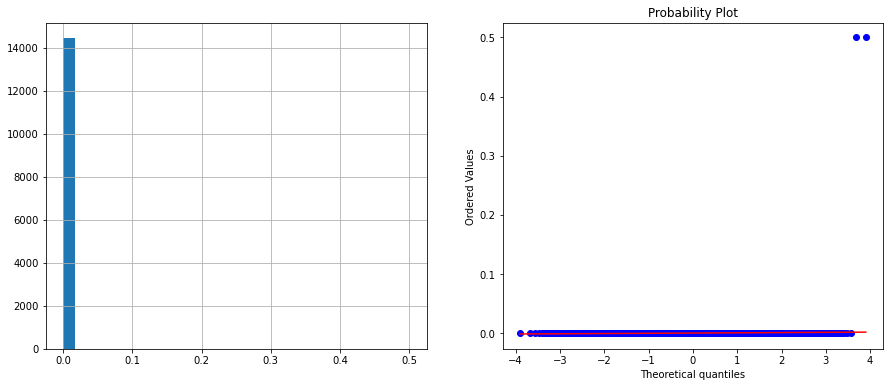

In [62]:
data['ocean_proximity_inv'] = (1/(data['ocean_proximity']))
plot_density_qq(data, 'ocean_proximity_inv')

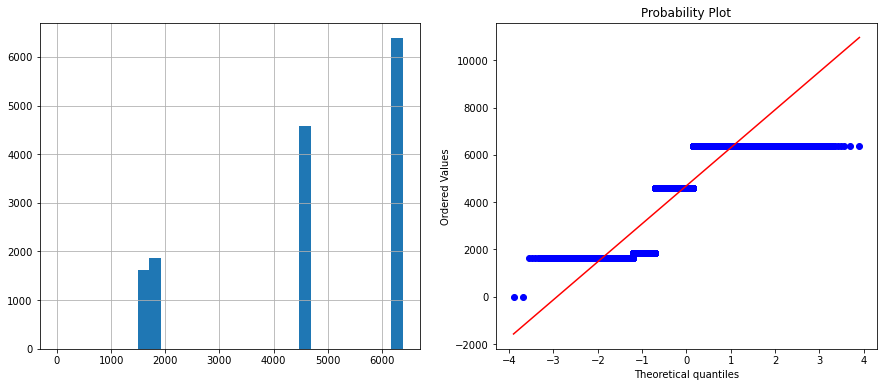

In [63]:
data['ocean_proximity_cuad'] = (data['ocean_proximity']^2)
plot_density_qq(data, 'ocean_proximity_cuad')

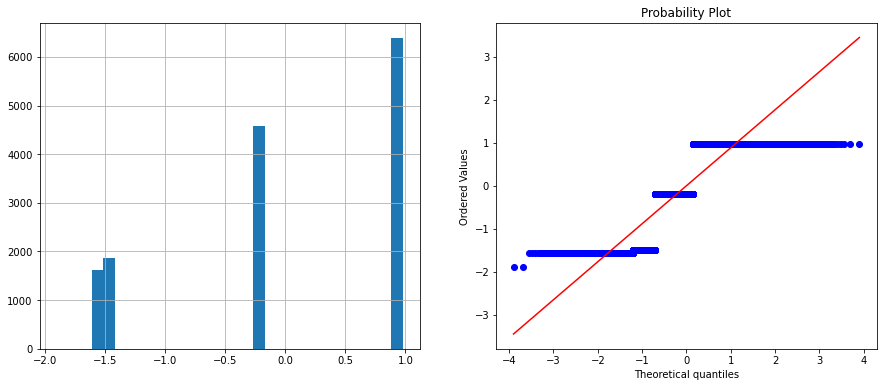

In [64]:
pt = PowerTransformer(method='yeo-johnson')
data['ocean_proximity_yeoJohnson'] = pt.fit_transform(data['ocean_proximity'].values.reshape(-1, 1))
plot_density_qq(data, 'ocean_proximity_yeoJohnson')

In [65]:
data.describe()

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_rooms_log,...,housing_median_age_boxcox,total_bedrooms_boxcox,population_boxcox,households_boxcox,median_income_boxcox,median_house_value_boxcox,ocean_proximity_boxcox,ocean_proximity_inv,ocean_proximity_cuad,ocean_proximity_yeoJohnson
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,...,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,1.444700e+04
mean,10275.451997,28.845435,2635.287534,537.780854,1425.171454,500.116772,3.863949,206873.687824,4693.277151,7.627917,...,17.915489,12.852710,17.574662,13.363021,1.326190,28.034909,444192.779851,0.000346,4694.828338,-2.434545e-16
std,5957.136373,12.585221,2215.285809,421.997029,1123.733449,386.181946,1.892919,115263.889710,1833.712940,0.748915,...,7.119557,2.637566,3.469640,2.853344,0.523384,2.525379,233820.781023,0.005882,1834.466210,1.000035e+00
min,1.000000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,14999.000000,2.000000,0.693147,...,0.000000,0.000000,2.210702,0.000000,-0.672282,18.466001,1.261435,0.000157,0.000000,-1.899553e+00
25%,5139.500000,18.000000,1444.000000,297.000000,786.000000,280.000000,2.567150,119600.000000,4577.000000,7.275172,...,11.950638,11.338289,15.594978,11.755179,0.983697,26.235953,397261.541956,0.000157,4579.000000,-2.008554e-01
50%,10210.000000,29.000000,2121.000000,436.000000,1163.000000,408.000000,3.535000,179700.000000,4577.000000,7.659643,...,18.298673,12.735258,17.454320,13.237971,1.336795,28.007731,397261.541956,0.000218,4579.000000,-2.008554e-01
75%,15449.000000,37.000000,3137.500000,644.000000,1722.000000,604.500000,4.722850,264600.000000,6384.000000,8.051182,...,22.643397,14.280381,19.490192,14.933197,1.665379,29.776266,672982.719044,0.000218,6386.000000,9.785691e-01
max,20640.000000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,6384.000000,10.579489,...,30.378758,26.668364,40.787007,28.778722,3.064260,32.875428,672982.719044,0.500000,6386.000000,9.785691e-01


### Se eliminan las columnas anteriores y se dejan solo las columnas transformadas

In [66]:
data = data.drop(['housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity'], axis=1)

In [67]:
data.describe()

,id,total_rooms_log,total_rooms_inv,total_rooms_cuad,total_rooms_boxcox,total_rooms_yeoJohnson,housing_median_age_boxcox,total_bedrooms_boxcox,population_boxcox,households_boxcox,median_income_boxcox,median_house_value_boxcox,ocean_proximity_boxcox,ocean_proximity_inv,ocean_proximity_cuad,ocean_proximity_yeoJohnson
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,1.444700e+04,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,1.444700e+04
mean,10275.451997,7.627917,0.000815,2635.312314,19.344132,-6.280633e-16,17.915489,12.852710,17.574662,13.363021,1.326190,28.034909,444192.779851,0.000346,4694.828338,-2.434545e-16
std,5957.136373,0.748915,0.005015,2215.275173,3.627022,1.000035e+00,7.119557,2.637566,3.469640,2.853344,0.523384,2.525379,233820.781023,0.005882,1834.466210,1.000035e+00
min,1.000000,0.693147,0.000025,0.000000,0.746684,-5.017105e+00,0.000000,0.000000,2.210702,0.000000,-0.672282,18.466001,1.261435,0.000157,0.000000,-1.899553e+00
25%,5139.500000,7.275172,0.000319,1444.500000,17.343201,-5.516705e-01,11.950638,11.338289,15.594978,11.755179,0.983697,26.235953,397261.541956,0.000157,4579.000000,-2.008554e-01
50%,10210.000000,7.659643,0.000471,2121.000000,19.217139,-3.467024e-02,18.298673,12.735258,17.454320,13.237971,1.336795,28.007731,397261.541956,0.000218,4579.000000,-2.008554e-01
75%,15449.000000,8.051182,0.000693,3139.000000,21.289224,5.367196e-01,22.643397,14.280381,19.490192,14.933197,1.665379,29.776266,672982.719044,0.000218,6386.000000,9.785691e-01
max,20640.000000,10.579489,0.500000,39322.000000,39.739022,5.612550e+00,30.378758,26.668364,40.787007,28.778722,3.064260,32.875428,672982.719044,0.500000,6386.000000,9.785691e-01


In [68]:
data = data.drop(['total_rooms_log','total_rooms_inv','total_rooms_cuad','total_rooms_yeoJohnson','ocean_proximity_boxcox','ocean_proximity_cuad','ocean_proximity_yeoJohnson'], axis=1)

In [69]:
data.describe()

,id,total_rooms_boxcox,housing_median_age_boxcox,total_bedrooms_boxcox,population_boxcox,households_boxcox,median_income_boxcox,median_house_value_boxcox,ocean_proximity_inv
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,19.344132,17.915489,12.852710,17.574662,13.363021,1.326190,28.034909,0.000346
std,5957.136373,3.627022,7.119557,2.637566,3.469640,2.853344,0.523384,2.525379,0.005882
min,1.000000,0.746684,0.000000,0.000000,2.210702,0.000000,-0.672282,18.466001,0.000157
25%,5139.500000,17.343201,11.950638,11.338289,15.594978,11.755179,0.983697,26.235953,0.000157
50%,10210.000000,19.217139,18.298673,12.735258,17.454320,13.237971,1.336795,28.007731,0.000218
75%,15449.000000,21.289224,22.643397,14.280381,19.490192,14.933197,1.665379,29.776266,0.000218
max,20640.000000,39.739022,30.378758,26.668364,40.787007,28.778722,3.064260,32.875428,0.500000


### Vemos el DataFrame BackUp para comparar los valores y poder ver la diferencia una vez se hizo la transformación de variables

In [70]:
data_backup.describe()

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_bedrooms_media,ocean_proximity_freq
count,14447.000000,14447.000000,14447.000000,14310.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,28.845435,2635.287534,537.778756,1425.171454,500.116772,3.863949,206873.687824,537.780854,4693.277151
std,5957.136373,12.585221,2215.285809,424.012399,1123.733449,386.181946,1.892919,115263.889710,421.997029,1833.712940
min,1.000000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,14999.000000,1.000000,2.000000
25%,5139.500000,18.000000,1444.000000,295.000000,786.000000,280.000000,2.567150,119600.000000,297.000000,4577.000000
50%,10210.000000,29.000000,2121.000000,433.000000,1163.000000,408.000000,3.535000,179700.000000,436.000000,4577.000000
75%,15449.000000,37.000000,3137.500000,647.000000,1722.000000,604.500000,4.722850,264600.000000,644.000000,6384.000000
max,20640.000000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,6445.000000,6384.000000


# 9. Feature Scaling

In [71]:
column_mapping = {'total_rooms_boxcox':'total_rooms',
                  'housing_median_age_boxcox':'housing_median_age',
                  'total_bedrooms_boxcox':'total_bedrooms',
                  'population_boxcox':'population',
                  'households_boxcox':'households',
                  'median_income_boxcox':'median_income',
                  'median_house_value_boxcox':'median_house_value',
                  'ocean_proximity_inv':'ocean_proximity'}

In [72]:
data = data.rename(columns=column_mapping)

In [73]:
data.describe()

,id,total_rooms,housing_median_age,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,19.344132,17.915489,12.852710,17.574662,13.363021,1.326190,28.034909,0.000346
std,5957.136373,3.627022,7.119557,2.637566,3.469640,2.853344,0.523384,2.525379,0.005882
min,1.000000,0.746684,0.000000,0.000000,2.210702,0.000000,-0.672282,18.466001,0.000157
25%,5139.500000,17.343201,11.950638,11.338289,15.594978,11.755179,0.983697,26.235953,0.000157
50%,10210.000000,19.217139,18.298673,12.735258,17.454320,13.237971,1.336795,28.007731,0.000218
75%,15449.000000,21.289224,22.643397,14.280381,19.490192,14.933197,1.665379,29.776266,0.000218
max,20640.000000,39.739022,30.378758,26.668364,40.787007,28.778722,3.064260,32.875428,0.500000


In [74]:
continuas

['id',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [75]:
data.copy()[continuas].head()

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,9744,10.111986,19.382511,12.003328,17.398640,12.386177,1.683266,29.075695
1,13893,22.643397,12.527154,8.200022,9.981198,6.844312,1.396815,23.791869
2,18277,21.574118,16.388156,9.753115,13.741488,10.079233,2.184740,32.875428
3,16176,30.378758,8.435327,4.595549,5.592071,4.980139,2.584431,29.024964
4,8843,17.741766,22.665167,17.609230,19.728534,18.380421,0.988455,29.921116


In [76]:
data_temp = data.copy()[continuas]

In [77]:
scaler = StandardScaler()
scaler.fit(data_temp) # Se extrae o se calcula info interna (parametros) para transformaciones posteriores.

data_scaled = scaler.transform(data_temp)
data_scaled = pd.DataFrame(data_scaled, columns=data_temp.columns)




In [79]:
data_scaled.describe()

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,1.444700e+04,1.444700e+04,1.444700e+04,1.444700e+04,1.444700e+04,1.444700e+04,1.444700e+04,1.444700e+04
mean,-5.803561e-17,1.003327e-16,-4.731378e-16,3.324752e-16,-4.573993e-16,6.113412e-16,2.680458e-16,1.959931e-16
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-1.724790e+00,-2.516464e+00,-5.127647e+00,-4.873112e+00,-4.428267e+00,-4.683447e+00,-3.818497e+00,-3.789229e+00
25%,-8.621810e-01,-8.378412e-01,-5.516922e-01,-5.741935e-01,-5.705930e-01,-5.635132e-01,-6.544051e-01,-7.123755e-01
50%,-1.098754e-02,5.382316e-02,-3.501411e-02,-4.453217e-02,-3.468547e-02,-4.382718e-02,2.026315e-02,-1.076235e-02
75%,8.684923e-01,6.640962e-01,5.362966e-01,5.413021e-01,5.521022e-01,5.503124e-01,6.480900e-01,6.895665e-01
max,1.739914e+00,1.750629e+00,5.623234e+00,5.238212e+00,6.690362e+00,5.402866e+00,3.320944e+00,1.916816e+00


In [80]:
round(data_scaled.describe(), 2)

,id,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.72,-2.52,-5.13,-4.87,-4.43,-4.68,-3.82,-3.79
25%,-0.86,-0.84,-0.55,-0.57,-0.57,-0.56,-0.65,-0.71
50%,-0.01,0.05,-0.04,-0.04,-0.03,-0.04,0.02,-0.01
75%,0.87,0.66,0.54,0.54,0.55,0.55,0.65,0.69
max,1.74,1.75,5.62,5.24,6.69,5.40,3.32,1.92


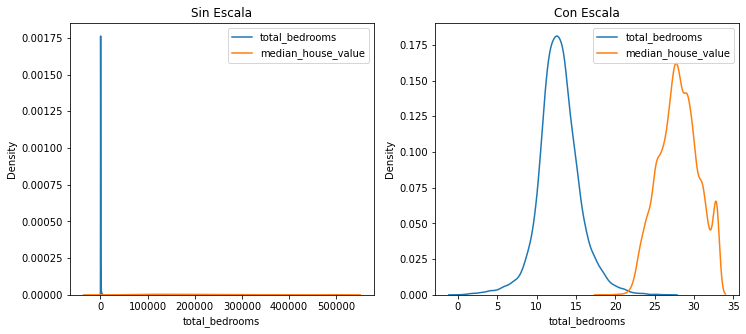

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

ax1.set_title("Sin Escala")
sns.kdeplot(data_backup['total_bedrooms'], ax=ax1, label="total_bedrooms")
sns.kdeplot(data_backup['median_house_value'], ax=ax1, label="median_house_value")

ax2.set_title("Con Escala")
sns.kdeplot(data_temp['total_bedrooms'], ax=ax2, label="total_bedrooms")
sns.kdeplot(data_temp['median_house_value'], ax=ax2, label="median_house_value")

ax1.legend()
ax2.legend()

plt.show()

# 10. Configuración del Pipeline

In [83]:

#imputación de variables categóricas
#CATEGORICAL_VARS_WITH_NA_FREQUENT = ['ocean_proximity']

#imputación de variables categoricas con indicador de Faltante (Missing)
#CATEGORICAL_VARS_WITH_NA_MISSING = ['ocean_proximity']

#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['total_bedrooms']

#Variables temporales
#TEMPORAL_VARS = ['YearRemodAdd']

#Año de Referencia
#REF_VAR = "YrSold"

#Variables para Binarización por sesgo
#BINARIZE_VARS = ['ScreenPorch']

#Variables que eliminaremos
DROP_FEATURES = ["id","longitude", "latitude"]

#Variables para transfomraicón logarítmica
#NUMERICAL_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]

#Variables para codificación ordinal.
#QUAL_VARS = ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu']

#variables especiales
#EXPOSURE_VARS = ['BsmtExposure']

#FINISH_VARS = ['BsmtFinType1']

#GARAGE_VARS = ['GarageFinish']

#FENCE_VARS = ['Fence']

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['ocean_proximity']

#Mapeo para varibels categótricas para calidad.
QUAL_MAPPINGS = {'1H OCEAN': 1, 'INLAND': 2, 'NEAR BAY': 3,
                 'NEAR OCEAN': 4, 'ISLAND': 5}


#Variables a utilzar en el entrenamiento
FEATURES = [
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'ocean_proximity',
    
]

# 11. Seleccionar Variables de Interes

In [84]:
X_train = X_train[FEATURES]

# 12. Tratar la Variable Target

In [85]:
y_train = np.log(y_train)
y_test = np.log(y_test)

# 13. Construcción de Pipeline

In [86]:
# importamos el preprocessor

import myPreprocessors as mypp #cargamos nuestros operadores

In [87]:
housePrice_pipeline_v06062023 = Pipeline([
    # IMPUTACIONES
    # 1. Imputación de Variables Categóricas
    
    #('missing_imputation',
     #        CategoricalImputer(imputation_method='missing', 
      #                variables=CATEGORICAL_VARS_WITH_NA_MISSING)),
    
    # 2. Imputación de Variables Categóricas basadas en Frecuencia
    #('frequent_imputation',
     #       CategoricalImputer(imputation_method='frequent',
      #                        variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),
    
    # 3. Imputación de Variables Numéricas
    ('mean_imputation',
            MeanMedianImputer(imputation_method='mean',
                             variables=NUMERICAL_VARS_WITH_NA)),
    
    # 4. Codificación de Variables Categóricas
    #('quality_mapper',
     #       mypp.Mapper(variables=QUAL_VARS,
      #                 mappings = QUAL_MAPPINGS)),
    
    #('exposure_ymapper',
     #       mypp.Mapper(variables=EXPOSURE_VARS,
      #                 mappings = EXPOSURE_MAPPINGS)),
    
    #('finish_mapper',
     #       mypp.Mapper(variables=FINISH_VARS,
      #                 mappings = FINISH_MAPPINGS)),
    
    #('garage_mapper',
     #       mypp.Mapper(variables=GARAGE_VARS,
      #                 mappings = GARAGE_MAPPINGS)),
    
    
    #('categorical_encoder',
     #       CountFrequencyEncoder(encoding_method='count',
      #                           variables = CATEGORICAL_VARS)),
    ('categorical_encoder',
        OrdinalEncoder(encoding_method='ordered', variables=CATEGORICAL_VARS)
    ),
    
    
    # 5. Transformación de Variables Continuas
    #('log_transform',
     #       LogTransformer(variables=NUMERICAL_LOG_VARS)),
    
    # 6. Feature Scaling
    ('scaler',
            MinMaxScaler()
    ),
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2022)
    )

])

# 14. Pipeline Generado

In [88]:
housePrice_pipeline_v06062023.fit(X_train, y_train)

Pipeline(steps=[('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_bedrooms'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2022))])

In [89]:
X_test = X_test[FEATURES]

In [90]:
preds = housePrice_pipeline_v06062023.predict(X_test)

In [91]:
rmseTest = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds)))
rmseTest

87393.65511995174

In [92]:
np.min(np.exp(y_train)), np.max(np.exp(y_train))

(22499.99999999999, 500000.99999999977)

In [93]:
rmseTest / (np.max(np.exp(y_train)) - np.min(np.exp(y_train)))

0.1830229782135572

In [94]:
#guardamos pipeline para uso en producción.
joblib.dump(housePrice_pipeline_v06062023, 'housePrice_pipeline_v06062023.pkl')

['housePrice_pipeline_v06062023.pkl']

In [95]:
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']

# 15. Generación de Nuevo Archivo CSV ya con los valores nuevos transformados

In [96]:
# Se agrega el nuevo nombre del archivo a generar
new_file_name = "new_outcome_data.csv"

# Exportamos el DataFrame nuevo a CSV
data.to_csv(new_file_name, index=False)